In [1]:
import sys
sys.path[0]="/Users/kwaneu/research/velocity/"
print(sys.path)
import pandas as pd
import numpy as np
import velocity
from velocity.chemistry import Species, Reaction, Network
from math import sqrt
import lmfit
from tqdm.notebook import tqdm
from IPython.display import display, HTML
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

['/Users/kwaneu/research/velocity/', '/Users/kwaneu/research/velocity/sugar/sugar_grid', '/Users/kwaneu/miniconda3/envs/python/lib/python39.zip', '/Users/kwaneu/miniconda3/envs/python/lib/python3.9', '/Users/kwaneu/miniconda3/envs/python/lib/python3.9/lib-dynload', '', '/Users/kwaneu/miniconda3/envs/python/lib/python3.9/site-packages', '/Users/kwaneu/miniconda3/envs/python/lib/python3.9/site-packages/IPython/extensions', '/Users/kwaneu/.ipython']


In [2]:
# make a simplified deuterated reaction network of the form:
#
# allow all H/D variants at site A (but not at sites X or Y):
# {sugar1_HHH,sugar1_DHH} == site_A_radical == {sugar2_H,sugar2_D}
# 
# allow unproductive H/D exchange at sites X and Y (single substitutions only):
# sugar1_HDH <- site_X_radical == sugar1_HHH == site_Y_radical -> sugar1_HHD
#
# KIE = 1 assumed
def make_deuteration_network(
    abundance,             # fraction from 0 to 1 of deuterium
    base_rate_constant_A,  # of desired site A
    base_rate_constant_X,  # of undesired site X
    base_rate_constant_Y,  # of undesired site Y
    HAA_selectivity,       # preference for destroying sugar 1 over sugar 2
    HAD_selectivity,       # preference for regenerating sugar 2 over sugar 1
    commitment = 1000.0,   # ratio of HAD rate constant to HAA rate constant
    conversion = 1e-6      # base rate constants will be converted to actual rate constants by this scaling factor
):
    # abbreviations
    a = abundance
    bA, bX, bY = base_rate_constant_A*conversion, base_rate_constant_X*conversion, base_rate_constant_Y*conversion
    HAA, HAD = HAA_selectivity, HAD_selectivity
    c = commitment

    # setup species
    # xyz nomenclature refers to desired site A, undesired site X, undesired site Y
    # H/D indicates the isotope at each site
    sugar1_HHH = Species("1_HHH", "sugar 1 HHH")
    sugar1_DHH = Species("1_DHH", "sugar 1 DHH")
    sugar1_HDH = Species("1_HDH", "sugar 1 HDH")
    sugar1_HHD = Species("1_HHD", "sugar 1 HHD")
    sugar2_H   = Species("2_H",   "sugar 2 H")
    sugar2_D   = Species("2_D",   "sugar 2 D")
    Adot       = Species("A_dot", "site A radical")
    Xdot       = Species("X_dot", "site X radical")
    Ydot       = Species("Y_dot", "site Y radical")
    cat        = Species("cat",   "catalyst")
    
    # setup reactions
    reactions_dict = {}
    
    # sugar1_HHH == Adot == sugar2_H
    reaction1 = Reaction({sugar1_HHH:1, cat:1}, {Adot:1, cat:1}, reversible=True)
    reaction2 = Reaction({Adot:1, cat:1}, {sugar2_H:1, cat:1}, reversible=True)
    reactions_dict[reaction1] = (bA*sqrt(HAA), (1-a)*bA*c/sqrt(HAD))
    reactions_dict[reaction2] = ((1-a)*bA*c*sqrt(HAD), bA/sqrt(HAA))
    
    # sugar1_DHH == Adot == sugar2_D
    reaction3 = Reaction({sugar1_DHH:1, cat:1}, {Adot:1, cat:1}, reversible=True)
    reaction4 = Reaction({Adot:1, cat:1}, {sugar2_D:1, cat:1}, reversible=True)
    reactions_dict[reaction3] = (bA*sqrt(HAA), a*bA*c/sqrt(HAD))
    reactions_dict[reaction4] = (a*bA*c*sqrt(HAD), bA/sqrt(HAA))
    
    # sugar1_HDH <- site_X_radical == sugar1_HHH
    reaction5 = Reaction({sugar1_HHH:1, cat:1}, {Xdot:1, cat:1}, reversible=True)
    reaction6 = Reaction({Xdot:1, cat:1}, {sugar1_HDH:1, cat:1})
    reactions_dict[reaction5] = (bX, (1-a)*bX*c)
    reactions_dict[reaction6] = a*bX*c
    
    # sugar1_HHH == site_Y_radical -> sugar1_HHD
    reaction7 = Reaction({sugar1_HHH:1, cat:1}, {Ydot:1, cat:1}, reversible=True)
    reaction8 = Reaction({Ydot:1, cat:1}, {sugar1_HHD:1, cat:1})
    reactions_dict[reaction7] = (bY, (1-a)*bY*c)
    reactions_dict[reaction8] = a*bY*c    
    
    # return result
    network = Network(reactions_dict, fixed_concentrations=None)
    return network, sugar1_HHH, cat

In [102]:
# model glucose/allose experiment
network, sugar1_HHH, cat = make_deuteration_network(
    abundance = 0.7,
    base_rate_constant_A = 13000, # allose (C3)
    base_rate_constant_X = 1000,   # mannose (C2)
    base_rate_constant_Y = 1000,   # galactose (C4)
    HAA_selectivity = 1.2,
    HAD_selectivity = 5.0,
    commitment = 10000.0,
)

initial_concentrations_dict = {
    sugar1_HHH : 0.2,
    cat : 0.2*0.02,
}
t_span = (0.0, 3600.0)
t_eval = np.arange(0, 3605.0, 5.0)
concentrations_df = network.simulate_timecourse(initial_concentrations_dict, t_span, t_eval)

time
0.0             NaN
5.0       91.531893
10.0      86.180110
15.0      81.890912
20.0      78.467980
            ...    
3580.0    53.948910
3585.0    53.946959
3590.0    53.947089
3595.0    53.944203
3600.0    53.944505
Length: 721, dtype: float64

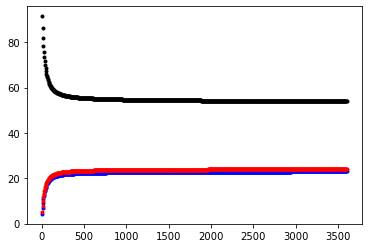

In [103]:
df = concentrations_df
recovered_A = df["1_DHH"] * 100.0 / (df["1_DHH"] + df["1_HDH"] + df["1_HHD"])
recovered_X = df["1_HDH"] * 100.0 / (df["1_DHH"] + df["1_HDH"] + df["1_HHD"])
recovered_Y = df["1_HHD"] * 100.0 / (df["1_DHH"] + df["1_HDH"] + df["1_HHD"])
plt.plot(concentrations_df.index, recovered_A, "k.")
plt.plot(concentrations_df.index, recovered_X, "b.")
plt.plot(concentrations_df.index, recovered_Y+1, "r.")
recovered_A

In [104]:
df = concentrations_df.loc[1800]
display(df)
#df = df.iloc[0]

cat      0.004000
A_dot    0.000007
X_dot    0.000018
Y_dot    0.000018
1_DHH    0.002246
1_HDH    0.000943
1_HHD    0.000943
1_HHH    0.179647
2_D      0.011324
2_H      0.004853
Name: 1800.0, dtype: float64

In [105]:
recovered_A = df["1_DHH"] * 100.0 / (df["1_DHH"] + df["1_HDH"] + df["1_HHD"])
recovered_X = df["1_HDH"] * 100.0 / (df["1_DHH"] + df["1_HDH"] + df["1_HHD"])
recovered_Y = df["1_HHD"] * 100.0 / (df["1_DHH"] + df["1_HDH"] + df["1_HHD"])
deuteration = (df["1_DHH"] + df["1_HDH"] + df["1_HHD"])*100.0/(df["1_DHH"] + df["1_HDH"] + df["1_HHD"] + df["1_HHH"])
print(f"A:{recovered_A:.1f}%  X:{recovered_X:.1f}%  Y:{recovered_Y:.1f}%   deuteration:{deuteration:.1f}%")

A:54.4%  X:22.8%  Y:22.8%   deuteration:2.2%


In [101]:
conversion = 1-df["1_HHH"]/0.2
print(conversion)

0.6480478064428945


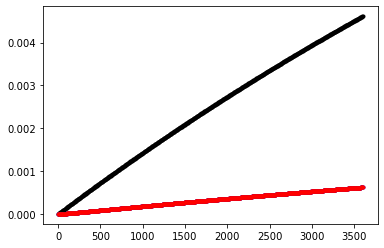

In [78]:
plt.plot(concentrations_df.index, concentrations_df["1_DHH"], "k.")
plt.plot(concentrations_df.index, concentrations_df["1_HDH"], "b.")
plt.plot(concentrations_df.index, concentrations_df["1_HHD"], "r.")

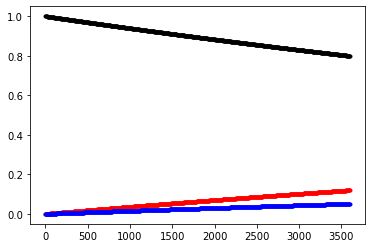

In [79]:
plt.plot(concentrations_df.index, concentrations_df["1_HHH"]/0.2, "k.")
#plt.plot(concentrations_df.index, concentrations_df["2_H"]/(concentrations_df["2_H"]+concentrations_df["2_D"]), "b.")
plt.plot(concentrations_df.index, concentrations_df["2_D"]/0.2, "r.")
plt.plot(concentrations_df.index, concentrations_df["2_H"]/0.2, "b.")